In [185]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import spectrogram
from cmath import cos, sin, pi

In [187]:
def PSD_cp(eeg_data,fs,plot,chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']):
    # Calculate the PSD of the filtered signal 
    f, Pxx_den = signal.welch(eeg_data, fs, nperseg=1024)

    if (plot == True):
        # Plot the PSD for each channel of the filtered signal
        for i in range(len(eeg_data)):
            plt.figure()
            plt.semilogy(f[0:201], Pxx_den[i][0:201])
            plt.xlabel('frequency [Hz]')
            plt.ylabel('PSD [V**2/Hz]')
            plt.title(chan_name[i])
            plt.show()
    return f, Pxx_den

In [188]:
def spectrogram_cp(eeg_data,fs,plot,chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']):
    # Define parameters for spectrogram
    nperseg = 1024  # Number of samples per segment
    noverlap = 512  # Number of samples overlapping between segments
    f_range = [0, 40]  # Frequency range of interest in Hz

    # Loop through each channel
    for channel_index in range(len(eeg_data)):
        # Compute the spectrogram for the current channel
        freqs, t, Sxx = spectrogram(eeg_data[channel_index], fs, nperseg=nperseg, noverlap=noverlap)

        # Select the frequency range of interest
        freq_idx = (freqs >= f_range[0]) & (freqs <= f_range[1])
        freqs = freqs[freq_idx]
        Sxx = Sxx[freq_idx, :]

        if (plot == True):
            # Plot the spectrogram and some visible lines at target_freqs in Hz
            plt.pcolormesh(t, freqs, 10 * np.log10(Sxx), cmap='jet')
            plt.colorbar(label='dB/Hz')
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title('Time-Frequency Spectrogram for Channel ' + chan_name[channel_index])
            plt.show()
    return freqs, t, Sxx

In [189]:
def zones_SNR_cp(eeg_data,target_frequency,fs,plot,left_channels_index,center_channels_index,right_channels_index,chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']):
    f, PSD_eeg = PSD_cp(eeg_data,fs,False,chan_name)

    # Calculate the average PSD of each zone  and plot it
    PSD_left = np.mean(PSD_eeg[left_channels_index], axis=0)
    PSD_center = np.mean(PSD_eeg[center_channels_index], axis=0)
    PSD_right = np.mean(PSD_eeg[right_channels_index],axis=0)
    #Keep only the frequencies between 1 and 40 Hz
    freq_idx = np.where((f >= 1) & (f <= 40))
    f = f[freq_idx]
    PSD_left = PSD_left[freq_idx]
    PSD_center = PSD_center[freq_idx]
    PSD_right = PSD_right[freq_idx]

    if (plot == True):
        # Plot the average PSD of each zone
        plt.figure()
        plt.plot(f, PSD_left, label='Left')
        plt.plot(f, PSD_center, label='Center')
        plt.plot(f, PSD_right, label='Right')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power (dB)')
        plt.title('Average PSD of each zone')
        plt.legend()
        plt.show()

    # Calculate the power for the target frequency in each zone
    power_left = np.mean(PSD_left[np.where((f >= target_frequency-1) & (f <= target_frequency+1))])
    power_center = np.mean(PSD_center[np.where((f >= target_frequency-1) & (f <= target_frequency+1))])   
    power_right = np.mean(PSD_right[np.where((f >= target_frequency-1) & (f <= target_frequency+1))])

    print('Power Left: ', power_left)
    print('Power Center: ', power_center)
    print('Power Right: ', power_right)

    # Calculate the SNR for the target frequency in each zone 
    SNR_left = power_left/np.mean(PSD_left[np.where((f >= 1) & (f <= 40))])
    SNR_center = power_center/np.mean(PSD_center[np.where((f >= 1) & (f <= 40))])
    SNR_right = power_right/np.mean(PSD_right[np.where((f >= 1) & (f <= 40))])

    print('SNR Left: ', SNR_left)
    print('SNR Center: ', SNR_center)
    print('SNR Right: ', SNR_right)
    
    return SNR_left, SNR_center, SNR_right

In [190]:
def rls_filter(y, x, P, lambda_, delta):
    # Initialize the filter coefficients
    w_all = np.zeros([P, len(y)])
    
    # Initialize the inverse correlation matrix as a numpy array
    R = delta*np.eye(P) 
    
    # Initialize the output signal
    x_hat = np.zeros([len(y),1])
    
    # Initialize the error signal
    e = np.zeros([len(y),1])
    
    # Loop through the input signal
    for i in np.arange(P+1, len(x), 1): 
        # P samples in x
        y_tmp = y[i-(P-1):i+1] # We need the i+1 here because of python's convention to select values up to the last index-1
        y_P = y_tmp[::-1] # reverse the columns so y(i) is the first element
        y_P = np.array(y_P) # Convert y_P to a numpy array
        y_P = np.reshape(y_P, (P,1))
        
        # 1. Compute the adaptation gain
        k_num = (1/lambda_)*(R@y_P)  # This is the previous Phi_xx at (m-1), but current x(m)
        k_den = 1 + (1/lambda_)*(y_P.T@R@y_P)
        k  = k_num/k_den
        k = np.reshape(k, (P,1))
        
        # 2. Error signal & update signal estimate
        x_hat[i] = (w_all[:,i-1].T)@y_P
        e[i] = x[i] - x_hat[i] 
        
        # 3. Update the filter coefficients
        w_all[:,i] = w_all[:,i-1] + k@e[i]
    
        # 4. Update the inverse correlation matrix
        R = (1/lambda_) * R - (1/lambda_)* k@y_P.T@R     
        
    return x_hat

In [191]:
# Load the raw EEG data
eeg_data = pd.read_csv("data/Liuyin-5April/Morning/wet_17hz_0504_clean_ExG.csv")
chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']
# Set the sampling rate and the filter cutoff frequencies
fs = 250
low_cutoff = 1
high_cutoff = 40
target_frequency = 17
target_frequencies = [17,34] # Best to use harmonics of the target frequency (only ints please the code is not smart enough to handle floats)

#Create two dataframes from eeg_data the first is the first column which is the timestamp and the second is the remaiing columns which are the EEG data
eeg_data_timestamp = eeg_data.iloc[:,0]
eeg_data_eeg = eeg_data.iloc[:,1:]

# Create an array of the EEG data
eeg_array = eeg_data_eeg.to_numpy() # 40672 rows x 8 columns (channels)
eeg_array = eeg_array.T # 8 rows (channels) x 40672 columns (samples)

# Apply a bandpass filter to the EEG data 
b, a = signal.butter(4, [low_cutoff/(fs/2), high_cutoff/(fs/2)], btype='bandpass')
eeg_filtered = signal.filtfilt(b, a, eeg_array, axis=1)

# Get information about the EEG data
# Get length of the EEG data
samples_nr = len(eeg_filtered[0])
# Get number of channels
channel_nr = len(eeg_filtered)
# Get the time vector
time = np.arange(0, samples_nr/fs, 1/fs)

# Introduce information about the channels
left_channels = ['PO3', 'PO7', 'O1']
center_channels = ['POz', 'Oz']
right_channels = ['PO4', 'PO8', 'O2']
zone_names = ['Left', 'Center', 'Right']

# Convert the channels to the corresponding index from chan_name
left_channels_index = [chan_name.index(i) for i in left_channels]
center_channels_index = [chan_name.index(i) for i in center_channels]
right_channels_index = [chan_name.index(i) for i in right_channels]

In [192]:
# Plot and save the PSD of the signal after filtering
# f, PSD_eeg = PSD_cp(eeg_filtered,fs,False,chan_name)
# Plot and save the Spectrogram of the signal after filtering
#freqs, t, Sxx = spectrogram_cp(eeg_filtered,fs,False,chan_name)

In [193]:
# Generate a desired signal with a target frequency and length n 
x = np.sin(2*np.pi*17*np.arange(samples_nr)/fs)

# Apply the recursive least squares filter to each of the channels in the EEG signal with a target frequency of 17 Hz
y_hat = []
for i in range(len(eeg_array)):
    y_hat.append(rls_filter(eeg_array[i], x, 2, 0.99, 1e-5))

# Transpose all elements in the list y_hat so that they are in the same format as the EEG signal
for i in range(len(y_hat)):
    y_hat[i] = y_hat[i].T

# Rearrange y_hat so it has same dimensions as eeg_array 
y_hat = np.array(y_hat)
y_hat = np.reshape(y_hat, (eeg_array.shape[0], eeg_array.shape[1]))

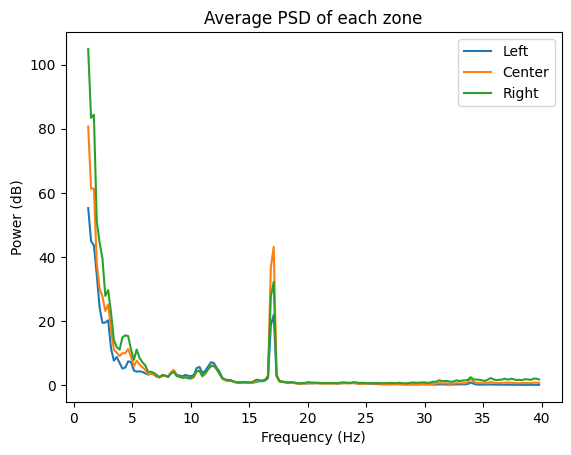

Power Left:  6.414570968170777
Power Center:  11.564279331439137
Power Right:  8.911518960302232
SNR Left:  1.82843106751221
SNR Center:  2.5200282172112005
SNR Right:  1.544130253718695


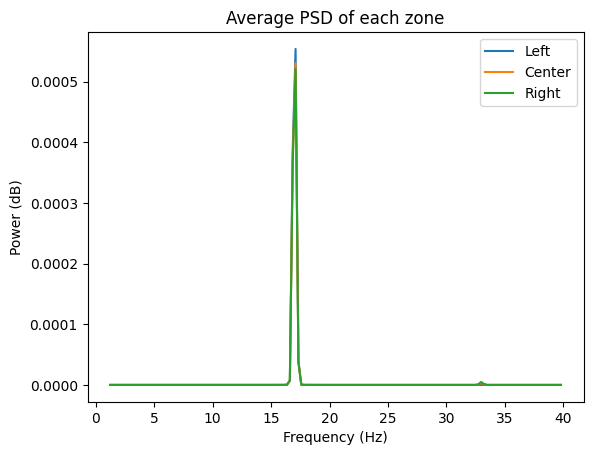

Power Left:  0.0001238946786272425
Power Center:  0.00011869106970716116
Power Right:  0.00011645008577144863
SNR Left:  19.865327792834513
SNR Center:  19.769050902947864
SNR Right:  19.710205909642067


In [200]:
SNR_left, SNR_center, SNR_right = zones_SNR_cp(eeg_array, target_frequency, fs, True,left_channels_index,center_channels_index,right_channels_index,chan_name)
SNR_left_rls, SNR_center_rls, SNR_right_rls = zones_SNR_cp(y_hat, target_frequency, fs, True,left_channels_index,center_channels_index,right_channels_index,chan_name)
